## **Identification de langues avec la tokenisation BERT ou Tiktoken**
## **et les classificateurs Naïve Bayes et Gradiant Boosting (rev2)**

### **1 - Contruction des classificateurs**

In [2]:
import pandas as pd
import random
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Choix de la Tokenisation (False = BERT, True Tiktoken)
titoken_tokenization = True

## Pour résoudre les problème de mémoire et de performances
nb_token_max = 2000
nb_phrase_lang = 56000

import warnings
warnings.filterwarnings('ignore')

#### **Lectures des phrases de "sentences.csv", et de leur étiquette "Langue" pour les langues sélectionnées**

In [3]:
# Ouvrir le fichier d'entrée en mode lecture
def create_lang_df(path):
    df = pd.read_csv(path, index_col ='id')
    return df

df_big = create_lang_df('../data/multilingue/sentences.csv')
lan_code = ['eng','fra','deu','spa','ita']
df = pd.DataFrame(columns=df_big.columns)
for i in range(len(lan_code)):
    df= pd.concat([df, df_big[df_big['lan_code']==lan_code[i]].iloc[:nb_phrase_lang]])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_rows = len(df)
print('Nombre de lignes de sentence.csv:',n_rows)
df

Nombre de lignes de sentence.csv: 280000


,lan_code,sentence
0,spa,"Figaro nos invitó a su boda, pero cuando llega..."
1,ita,Ho bisogno di parlarti stanotte.
2,deu,John arbeitet im Bereich Neuromarketing.
3,spa,Tú irás a la escuela.
4,deu,"Warum denkt jeder, ich sei dumm?"
...,...,...
279995,deu,Ich weiß absolut gar nichts darüber.
279996,ita,Marie ha capito.
279997,deu,"Um Missverständnisse zu vermeiden, hat er den ..."
279998,deu,Tom hatte seit Jahren kein Schwimmbad mehr von...


#### **Réalisation d'un jeu de données d'entrainement et de test**

In [8]:
# créer 2 dataframes: 1 train (50% des phrases) et 1 test (50% des phrases)
n_train = int(n_rows*0.5)
df_train = df.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df.iloc[n_train:].sample(frac=1, random_state=24).reset_index(drop=True)
pd.set_option('display.max_colwidth', 150)
display(df_train)
nb_phrases_lang =[]
for l in lan_code:
    nb_phrases_lang.append(sum(df_train['lan_code']==l))
print("Nombre de phrases par langue dans le jeu de données Train ",lan_code,":",nb_phrases_lang)

,lan_code,sentence
0,deu,Sie sagte: „Auf Wiedersehen!“
1,spa,Me lo he jugado el todo por el todo.
2,spa,Me pregunto si Tom y Mary están locos.
3,eng,I've lived here my whole life.
4,ita,Pensate che Mary sia troppo grassa per essere una cheerleader?
...,...,...
139995,deu,"„Das darf ich nicht verraten!“ – „Was würde passieren, wenn du’s doch tätest?“"
139996,ita,Ken è andato al supermercato a comprare delle uova.
139997,fra,"Si ton frère te dit : je suis pauvre, et j'ai froid, / Ton devoir est d'offrir la moitié de ton toit / À ton frère."
139998,deu,"Wir beabsichtigen mit allen Ländern, die uns umgeben, friedlich zusammenzuarbeiten."


Nombre de phrases par langue dans le jeu de données Train  ['eng', 'fra', 'deu', 'spa', 'ita'] : [27860, 27929, 28006, 27986, 28219]


#### **Selection du tokenizer** en fonction de la variable titoken_tokenization

In [10]:
# Selection du tokenizer
if titoken_tokenization:
    import tiktoken
    tokenizer = tiktoken.get_encoding("cl100k_base")
else:
    from transformers import BertTokenizerFast
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

#### **Tokenisation des données sélectionnées**
##### (Train + Test pour repertorier l'ensemble des tokens utilisés)

In [11]:
from collections import Counter
import pickle

# Definition de fonction de sauvegarde et chargement du dictionnaire des tokens utilisés
def save_dict_token(dict_ids):
    with open('../data/dict_token', 'wb') as fichier:
        pickle.dump(dict_ids, fichier)

def load_dict_token():
    with open('../data/dict_token', 'rb') as fichier:
        dict_ids = pickle.load(fichier)
        # Définition d'une liste 'écrite' des tokens
        decoded_keys = [tokenizer.decode([key]) for key in list(dict_ids.keys())]
    return dict_ids, decoded_keys

# Création d'un dictionnaire de complet des Token ID à partir des phrases selectionnée
dict_ids = Counter(token for ligne in df['sentence'] for token in tokenizer.encode(ligne))

# Tri des tokens en fonction de leur fréquence (afin de pouvoir selectionner les plus utiles s'il l y en a trop pour faire le BOW)
dict_ids= sorted(dict_ids.items(), key=lambda x: x[1], reverse=True) 
print("Nombre de tokens avant plafonnement:",len(dict_ids))
print("Nombre de tokens après plafonnement:",min(len(dict_ids),nb_token_max))

# Limitation du nombre de token
dict_ids = dict(dict_ids[:nb_token_max])
######### save_dict_token(dict_ids) ######### 

# Définition d'une liste 'écrite' des tokens : decoded_keys
decoded_keys = [tokenizer.decode([key]) for key in list(dict_ids.keys())]
print("Liste des 50 tokens les plus fréquents:",decoded_keys[:50])

Nombre de tokens avant plafonnement: 33588
Nombre de tokens après plafonnement: 2000
Liste des 50 tokens les plus fréquents: ['.', ',', '?', ' a', ' de', ' la', ' que', 'Tom', ' un', ' the', ' in', ' to', 'I', "'", 'i', ' le', ' en', ' es', 'é', ' l', '!', 'o', ' ist', ' pas', ' Tom', ' me', 'Ich', ' di', ' is', 'Je', ' nicht', ' you', ' die', ' el', ' à', ' est', 'en', 'a', ' ne', ' è', ' d', ' se', ' no', ' una', ' zu', '¿', ' of', 'Il', ' du', "'t"]


#### **Création des Bags  Of Worlds** (Train + Test)

In [96]:
import numpy as np

# Créez un DataFrame BOW avec les phrases (lignes) et les fréquences de chaque token (colonnes)
def create_BOW(data):
    BOW = []
    try:
        if 'str' in str(type(data)):
            l_tokenised = tokenizer.encode(data)
            BOW.append([l_tokenised.count(token) for token in dict_ids])
        else:
            for ligne in data:
                l_tokenised = tokenizer.encode(ligne)
                BOW.append([l_tokenised.count(token) for token in dict_ids])
    except:
        BOW.append([tokenizer.encode(" ").count(token) for token in dict_ids])
    return BOW

In [13]:
X_train = create_BOW(df_train['sentence'])
y_train = df_train['lan_code'].values.tolist() 

In [14]:
X_test = create_BOW(df_test['sentence'])
y_test = df_test['lan_code'].values.tolist()

#### **Choix du nom du fichier de sauvegarde du classifieur**

In [15]:
def get_file_name(titoken_tokenization, classifier):
    if titoken_tokenization:
        return "id_lang_tiktoken_"+classifier+".pkl"
    else:
        return "id_lang_BERT_"+classifier+".pkl"

#### **Création d'un classificateur avec l'algorithme Naïve Bayes**

In [17]:
from sklearn import svm
from sklearn import naive_bayes

# On definit le classificateur Naive Bayes et on l'entraine sur les données Train:
# clf_nb = naive_bayes.MultinomialNB()  # BernoulliNB() # MultinomialNB() 
# clf_nb.fit(X_train, y_train)

# Save the model to a file
######### joblib.dump(clf_nb, "../data/"+get_file_name(titoken_tokenization,"nb")) ######### 

In [19]:
# Chargement du classificateur sauvé
clf_nb = joblib.load("../data/"+get_file_name(titoken_tokenization,"nb"))
dict_ids, decoded_keys = load_dict_token()

# Verification de l'efficacité du classificateur grace à la matrice confusion
y_pred_nb = clf_nb.predict(X_test)
accuracy_naive_bayes = accuracy_score(y_test, y_pred_nb)
print("Matrice de confusion du classificateur Naïve Bayes")
display(pd.crosstab(y_test,y_pred_nb,rownames=['Classe réelle'], colnames=['Classe prédite']))
print("Accuracy Naïve Bayes = {:.3f}".format(accuracy_naive_bayes))

Matrice de confusion du classificateur Naïve Bayes


Classe prédite,deu,eng,fra,ita,spa
Classe réelle,,,,,
deu,27944,11,9,20,10
eng,50,27947,21,70,52
fra,14,9,27835,86,127
ita,21,10,53,27486,211
spa,29,31,104,192,27658


Accuracy Naïve Bayes = 0.992


#### **Création d'un classificateur avec l'algorithme Gradiant Boosting**

> Attention le training de cet algorithme peut être très long<br>
> Il peut être interessant de charger le modèle entrainé (si vous l'avez sauvez préalablement)

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# On definit le classificateur GradientBoosting et on l'entraine sur les données Train:
# clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0).fit(X_train, y_train)

# Save the model to a file
######### joblib.dump(clf_gb, "../data/"+get_file_name(titoken_tokenization,"gb")) ######### 

In [21]:
# Chargement du classificateur sauvé
clf_gb = joblib.load("../data/"+get_file_name(titoken_tokenization,"gb"))
######### dict_ids, decoded_keys = load_dict_token() ######### 

# Verification de l'efficacité du classificateur grace à la matrice confusion
y_pred_gb = clf_gb.predict(X_test)
accuracy_gradiant_boosting = accuracy_score(y_test, y_pred_gb)
print("Matrice de confusion du classificateur Gradiant Boosting")
display(pd.crosstab(y_test,y_pred_gb,rownames=['Classe réelle'], colnames=['Classe prédite']))
print("Accuracy Gradiant Boosting = {:.3f}".format(accuracy_gradiant_boosting))

Matrice de confusion du classificateur Gradiant Boosting


Classe prédite,deu,eng,fra,ita,spa
Classe réelle,,,,,
deu,27341,163,79,149,262
eng,67,27697,13,58,305
fra,31,53,27212,298,477
ita,160,107,177,26662,675
spa,63,95,225,474,27157


Accuracy Gradiant Boosting = 0.972


#### **Definition de fonction identificateur de langue**

In [104]:
def lang_id_nb(sentences):
    return clf_nb.predict(create_BOW(sentences))

def lang_id_gb(sentences):
    return clf_gb.predict(create_BOW(sentences))

#### **Exemples d'utilisation**

In [105]:
# Instanciation d'un exemple
exemples = ["france is often snowy during spring , and it is relaxing in january .",
           "elle adore les voitures très luxueuses, et toi ?",
           "she loves very luxurious cars, don't you?",
           "vamos a la playa",
           "Ich heiße Keyne, und das ist wunderbar",
           "she loves you, mais elle te hait aussi, and das ist traurig", # Attention à cette phrase trilingue
           "I ate caviar.", 
           "Vogliamo visitare il Colosseo e nuotare nel Tevere."
          ]
lang_exemples = ['eng','fra','eng','spa','deu','en,fr,de','en','ita']

In [106]:
# Affichage des prédictions
print('Langue réelle                 :',lang_exemple)
print('Prédictions Naive Bayes       :',lang_id_nb(exemples))
print('Prédictions Gradiant Boosting :',lang_id_gb(exemples))

Langue réelle                 : ['eng', 'fra', 'eng', 'spa', 'deu', 'en,fr,de', 'en', 'ita']
Prédictions Naive Bayes       : ['eng' 'fra' 'eng' 'spa' 'deu' 'fra' 'ita' 'ita']
Prédictions Gradiant Boosting : ['eng' 'fra' 'eng' 'spa' 'deu' 'deu' 'eng' 'ita']


### **2 - Intreprétabilité du fonctionnement du classificateur Naive Bayes**

#### **Analyse en Composante Principale pour visualiser l'importance des tokens**
#### dans la détection de langue par le classifieur Naive Bayes

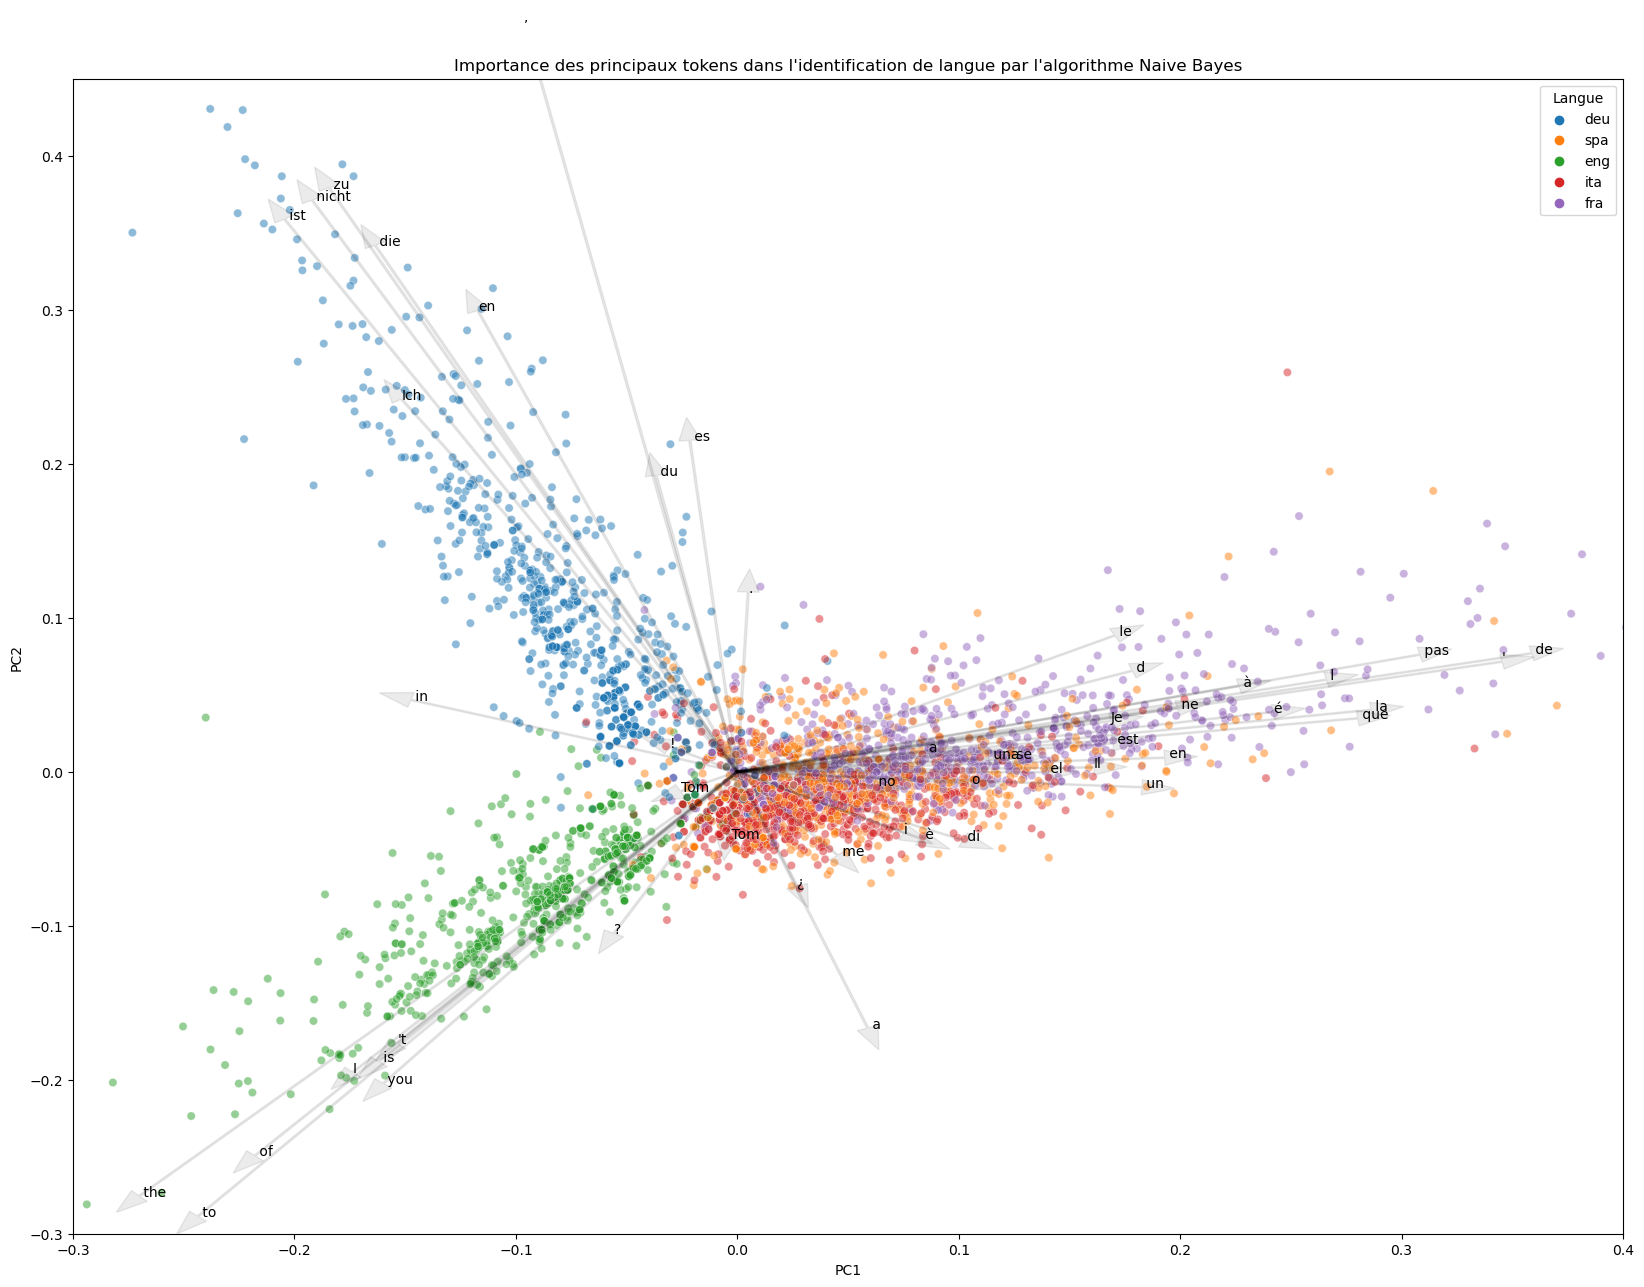

In [114]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Definition du nombre maximum de lignes pris en compte et du nombre maximum de tokens
max_lines = 5000
max_cols = 100
X = [ligne[:max_cols] for ligne in X_train[:max_lines]]
pd_X_train = pd.DataFrame(data=X, columns = decoded_keys[:max_cols])
# pd_X_train = pd.DataFrame(data=X_train, columns = decoded_keys)

n = pd_X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pd_X_train)

X_new = pca.fit_transform(X_train_scaled)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = clf_nb.predict(X_train)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='Langue')], axis=1)


plt.figure(figsize=(20, 15))

sns.scatterplot(x='PC1', y='PC2', hue='Langue', data=finalDF, alpha=0.5)

for i in range(min(n,50)):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.08, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, pd_X_train.columns[i], color='k')

plt.title("Importance des principaux tokens dans l'identification de langue par l'algorithme Naive Bayes") 
plt.xlim(-0.3, 0.4);
plt.ylim(-0.3, 0.45);

### **Algorithme LIME appliqué à une phrase mal classée par Naive Bayes**

In [127]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# Choix de la ligne d'exemple
ligne = 0

# Nous reconstruisons le même modèle mais avec des numpy arrays pour éviter les problème avec LIME du au nomns des features
features = np.array(create_BOW([exemples[ligne]]))
exp = LimeTabularExplainer(features, feature_names=list(decoded_keys), 
                           class_names=['deu', 'eng','fra','ita','spa'])
print("Phrase :",exemples[ligne])
print('Predicted Label:',lang_id_nb(exemples[ligne])," / probabilités = ",[round(e,3) for e in clf_nb.predict_proba(features)[0]])
exp.explain_instance(features[0], clf_nb.predict_proba, top_labels=6).show_in_notebook()

Phrase : france is often snowy during spring , and it is relaxing in january .
Predicted Label: ['eng']  / probabilités =  [0.0, 1.0, 0.0, 0.0, 0.0]


### **Interprétation du processus d'identification d'une langue avec Naïve Bayes**
#### 1- Création d'un BOW Train avec les Token ID en colonne + le lan_code

In [128]:
col_name = [str(key) for key in list(dict_ids.keys())]
df_BOW = pd.DataFrame(data=X_train, columns=col_name)
df_BOW['lan_code']=y_train
display(df_BOW.head())

,13,11,30,264,409,1208,1744,25763,653,279,...,3242,56321,2466,1283,4635,44283,7661,1654,70374,lan_code
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,deu
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spa
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spa
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,eng
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ita


#### 2- Calcul du nombre d'apparitions des tokens dans chaque langue
#### 3- Calcul de la probabilité d'apparition de chaque token dans chaque langue 
#### 4- Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue
![Formule probabilité Naïve Bayes](../images/formule_proba_naive_bayes.png)
> où **C** est la classe (*lan_code*), **Fi** est la *caractéristique i* du BOW, **Z** est l'*"evidence"* servant à regulariser la proba 

In [130]:
               
# Selection de la phrase à analyser
sel_phrase = 2
print("Phrase à analyser :\033[31;46m",lang_exemples[sel_phrase],'- "'+exemples[sel_phrase]+'\033[0m')

# Tokenisation et encodage de la phrase
encodage = tokenizer.encode(exemple[sel_phrase])
print("Nombre de tokens dans la phrase:",len(encodage))

# Création du vecteur BOW de la phrase
bow_exemple = create_BOW([exemple[sel_phrase]])
print("Nombre de tokens retenus dans le BOW:",sum(bow_exemple[0]))
masque_tokens_retenus = [(1 if token in dict_ids else 0) for token in encodage]
print("\033[96;43mTokens retenus\033[0m (se trouvant dans le modèle)     :",end="")
for i in range(len(encodage)):
    if masque_tokens_retenus[i]==1:
        print("\033[96;43m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")
    else: print("\033[31;47m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")

print("")
# Afin de continuer l'analyse on ne garde que les token de la phrase disponibles dans le BOW
token_used = [str(encodage[i]) for i in range(len(encodage)) if (masque_tokens_retenus[i]==1)]

# Calcul du nombre d'apparition de ces tokens dans le BOW pour chaque langue, et stockage dans un DataFrame df_count
def compter_non_zero(colonne):
    return (colonne != 0).sum()

votes = []
for i in range(len(lan_code)):
    #votes.append(list(df_BOW[token_used].loc[df_BOW['lan_code']==lan_code[i]].sum(axis=0)))
    votes.append(list(df_BOW[token_used].loc[df_BOW['lan_code']==lan_code[i]].apply(compter_non_zero)))

col_name = [str(i+1)+'-'+tokenizer.decode([int(token_used[i])]) for i in range(len(token_used))]
df_count = pd.DataFrame(data=votes,columns=token_used, index=lan_code)
df_count.columns = col_name
display(df_count)

# Calcul de la probabilité d'apparition de chaque token dans chaque langue
df_proba = df_count.div(nb_phrases_lang, axis = 0)

# Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue
df_proba['Proba'] = 1
# Itérer sur les colonnes et effectuez la multiplication pour chaque ligne
df_proba = df_proba.replace(0.0,0.000001)
for col in df_count.columns:
    df_proba['Proba'] *= df_proba[col]
# Multiplier par la probabilité de la classe
p_classe = [(nb_phrases_lang[i]/df_BOW.shape[0]) for i in range(len(nb_phrases_lang))]
df_proba['Proba'] *= p_classe
# Diviser par l'evidence
evidence = df_proba['Proba'].sum(axis=0)
df_proba['Proba'] *= 1/evidence
df_proba['Proba'] = df_proba['Proba'].round(3)


# Affichage de la matrice des probabilités
display(df_proba)
color = { 'deu':'\033[96;43m','eng':'\033[31;47m','fra':'\033[95;44m','ita':'\033[94;46m','spa':'\033[93;47m'}
print("      ",end=" ")
for i,token in enumerate(df_proba.columns):
    print(color[df_proba[token].idxmax()]+df_proba[token].idxmax(),end="\033[0m      ")
print("\n\n")

#        print("\033[96;43m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")
#    else: print("\033[31;47m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")
print("Langue réelle de la phrase                         : ",lang_exemple[sel_phrase])
print("Langue dont la probabilité est la plus forte       : ",df_proba['Proba'].idxmax()," (proba={:.2f}".format(max(df_proba['Proba']))+")")
prediction = clf_nb.predict(bow_exemple) 
print("Langue dont la probabilité prédite par Naiva Bayes : ",prediction[0]," (proba={:.2f}".format(max(clf_nb.predict_proba(create_BOW([exemple[sel_phrase]]))[0]))+")")

Phrase à analyser : eng - "she loves very luxurious cars, don't you?
Nombre de tokens dans la phrase: 10
Nombre de tokens retenus dans le BOW: 6
Tokens retenus (se trouvant dans le modèle)     :she  loves  very  luxurious  cars ,  don 't  you ? 


,1- very,"2-,",3- don,4-'t,5- you,6-?
eng,477,3069,824,3166,3416,2607
fra,0,3686,6,0,0,1225
deu,0,8976,0,0,0,3391
spa,1,3248,12,1,0,3519
ita,0,1986,13,1,0,4909


,1- very,"2-,",3- don,4-'t,5- you,6-?,Proba
eng,0.017121,0.110158,0.029576,0.113640,0.122613,0.093575,1.0
fra,0.000001,0.131978,0.000215,0.000001,0.000001,0.043861,0.0
deu,0.000001,0.320503,0.000001,0.000001,0.000001,0.121081,0.0
spa,0.000036,0.116058,0.000429,0.000036,0.000001,0.125741,0.0
ita,0.000001,0.070378,0.000461,0.000035,0.000001,0.173961,0.0


       eng      deu      eng      eng      eng      ita      eng      


Langue réelle de la phrase                         :  eng
Langue dont la probabilité est la plus forte       :  eng  (proba=1.00)
Langue dont la probabilité prédite par Naiva Bayes :  eng  (proba=1.00)


<BarContainer object of 5 artists>

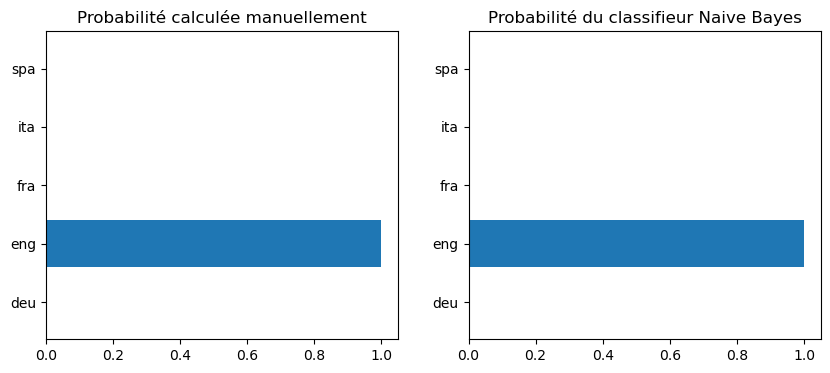

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

df_proba_sorted =df_proba.sort_index(ascending=True)
axs[0].set_title("Probabilité calculée manuellement")
axs[0].barh(df_proba_sorted.index, df_proba_sorted['Proba'])
axs[1].set_title("Probabilité du classifieur Naive Bayes")
axs[1].barh(df_proba_sorted.index, clf_nb.predict_proba(create_BOW([exemple[sel_phrase]]))[0])


Nombre de tokens dans la phrase: 10
Nombre de tokens retenus dans le BOW: 6
she loves very luxurious cars, don't you?   prédite ->  ['eng']
importance des tokens selon SKATER
[6/6] features ████████████████████ Time elapsed: 1 seconds

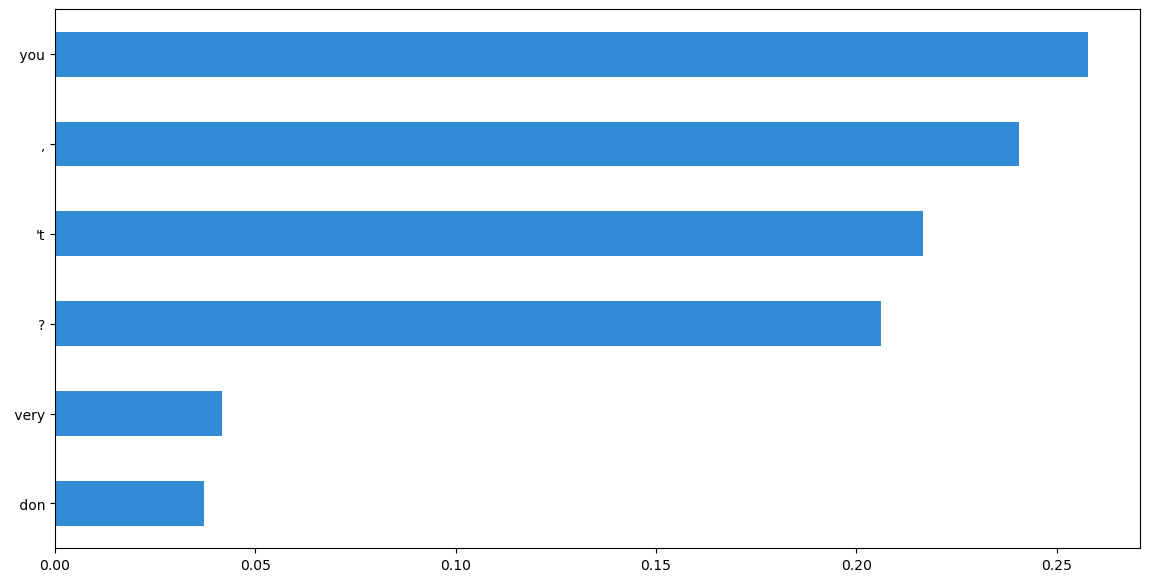

In [132]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt

def create_BOW_with_only_used_token(data, token_used):
    BOW = []
    for ligne in data:
        l_tokenised = tokenizer.encode(ligne)
        BOW.append([l_tokenised.count(int(token)) for token in token_used])
    return BOW

# Tokenisation et encodage de la phrase
encodage = tokenizer.encode(exemples[sel_phrase])
print("Nombre de tokens dans la phrase:",len(encodage))
token_used = list(set([str(encodage[i])  for i in range(len(encodage)) if encodage[i] in dict_ids]))
col_name = [tokenizer.decode([int(token_used[i])]) for i in range(len(token_used))]

# Création du vecteur BOW de la phrase
bow_exemple = create_BOW_with_only_used_token([exemples[sel_phrase]],  token_used)
print("Nombre de tokens retenus dans le BOW:",sum(bow_exemple[0]))

# Afin de continuer l'analyse on ne garde que les token de la phrase disponibles dans le BOW
df = df_BOW[token_used]
df.columns = col_name
df['lan_code'] = y_train
df = df.loc[~(df[col_name] == 0).all(axis=1)]
y_train_short = df['lan_code'].tolist()
df = df.drop(['lan_code'], axis=1)

interpreter = Interpretation(df, feature_names=col_name )

clf = naive_bayes.MultinomialNB()
clf.fit(df, y_train_short)
# clf.fit(df, y_train)
model = InMemoryModel(clf.predict_proba, examples = df)

print(exemple[sel_phrase],"  prédite -> ",clf.predict(bow_exemple))
plt.rcParams['figure.figsize'] = (14,7)
print('importance des tokens selon SKATER')
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=False)

In [133]:
import shap
from sklearn.preprocessing import MinMaxScaler

nb_lines = 4000
sc = MinMaxScaler()
X_train_new = df[:nb_lines ] #sc.fit_transform(df)
X_test_new = bow_exemple #sc.fit_transform(bow_exemple)
X_train_trans = pd.DataFrame(X_train_new, columns=col_name)
X_test_trans = pd.DataFrame(X_test_new, columns=col_name)
classifier = naive_bayes.MultinomialNB() # SVC(kernel = 'linear', random_state = 0,probability=True)
classifier.fit(X_train_trans.values, y_train_short[:nb_lines])



# classifier.score(X_test_trans,['ita'])


explainer = shap.KernelExplainer(classifier.predict_proba, X_train_trans) #kernel explainer requires background dataset 
                                                                        #which can be our train dataset. to generate perturb features
SHAP_values = explainer.shap_values(X_test_trans)

#Shap Force plot for 0th observation in test set

shap.initjs()



Using 4000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

In [134]:
print(' '*30+"\033[1mAllemand\033[0m")
display(shap.force_plot(explainer.expected_value[0], SHAP_values[0], X_test_trans)) # deu
print(' '*30+"\033[1mAnglais\033[0m")
display(shap.force_plot(explainer.expected_value[1], SHAP_values[1], X_test_trans)) # eng
print(' '*30+"\033[1mFrançais\033[0m")
display(shap.force_plot(explainer.expected_value[2], SHAP_values[2], X_test_trans)) # fra
print(' '*30+"\033[1mItalien\033[0m")
display(shap.force_plot(explainer.expected_value[3], SHAP_values[3], X_test_trans)) # ita
print(' '*30+"\033[1mEspagnol\033[0m")
display(shap.force_plot(explainer.expected_value[4], SHAP_values[4], X_test_trans)) # spa

                              Allemand


                              Anglais


                              Français


                              Italien


                              Espagnol


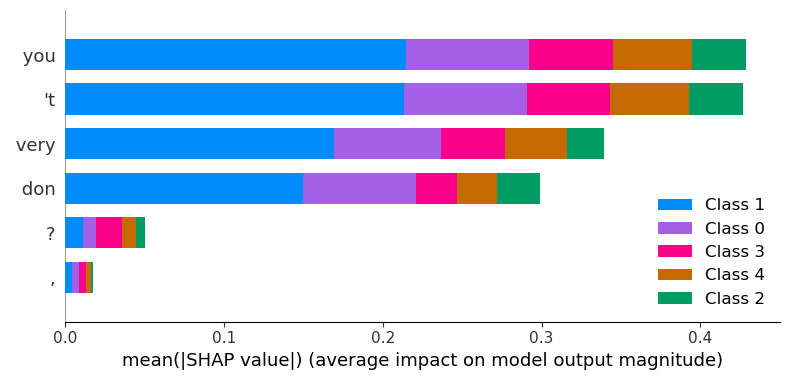

In [135]:
shap.summary_plot(SHAP_values, X_test_trans) #feature_names=['deu','eng','fra','ita','esp'])



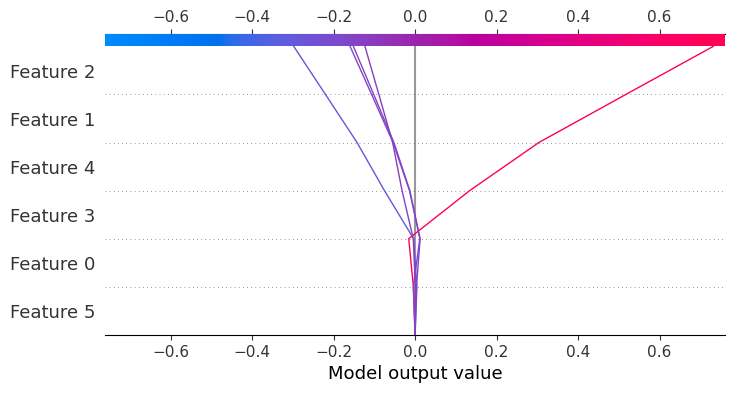

In [136]:
shap.multioutput_decision_plot([0,0,0,0,0],SHAP_values,0)

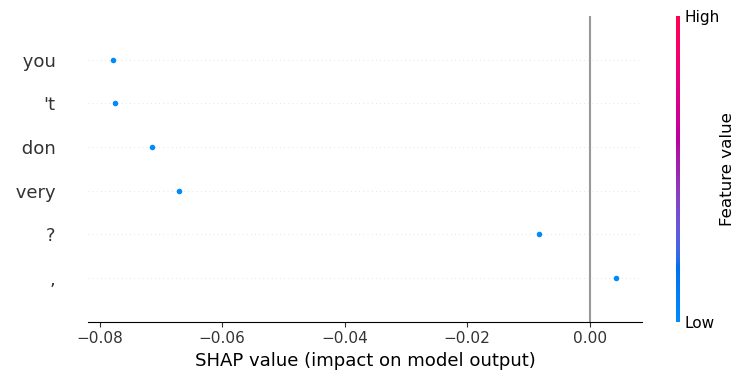

In [137]:
shap.summary_plot(SHAP_values[0], X_test_trans)

> Recherche des phrases mal classées par Naive Bayes

In [139]:
n_bad_max = 30
n_bad = 0
for i in range(len(y_test)):
    if (y_test[i] != y_pred_nb[i]) and (n_bad<n_bad_max):
        n_bad +=1
        print(n_bad,'- No',i,' - Réel:',y_test[i],' Prédit:',y_pred_nb[i],'    ',df_test['sentence'].iloc[i]," (proba={:.2f}".format(max(clf_nb.predict_proba(np.array(create_BOW([df_test['sentence'].iloc[i]])))[0]))+")")


1 - No 97  - Réel: eng  Prédit: ita      Good heavens!  (proba=0.32)
2 - No 114  - Réel: ita  Prédit: deu      Erano entrambe nude.  (proba=0.70)
3 - No 145  - Réel: fra  Prédit: spa      Tu es un opportuniste.  (proba=0.50)
4 - No 166  - Réel: spa  Prédit: fra      Sus calcetines son grises.  (proba=0.54)
5 - No 197  - Réel: spa  Prédit: ita      Llévame a casa.  (proba=0.81)
6 - No 210  - Réel: spa  Prédit: ita      Tom me vio.  (proba=0.51)
7 - No 257  - Réel: fra  Prédit: ita      Le chat attaque un rat.  (proba=0.84)
8 - No 386  - Réel: spa  Prédit: ita      Vi a Tom fumar un cigarrillo.  (proba=0.58)
9 - No 459  - Réel: fra  Prédit: spa      Tu es en premier.  (proba=0.78)
10 - No 633  - Réel: fra  Prédit: spa      Aucun corps.  (proba=0.67)
11 - No 679  - Réel: deu  Prédit: eng      Tom folgte meinem Rat.  (proba=0.45)
12 - No 1015  - Réel: eng  Prédit: deu      Fair, later cloudy.  (proba=0.33)
13 - No 1036  - Réel: ita  Prédit: spa      Devo fermarla.  (proba=0.80)
14 - No 111